# Initialize

In [1]:
%load_ext ipycache
%load_ext autoreload
%autoreload 2

/opt/conda/lib/python3.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/opt/conda/lib/python3.7/site-packages/ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


In [2]:
import os
import sys

comparisons_folder = os.getcwd()
src_folder = '/'.join(comparisons_folder.split('/')[:-2])
sys.path.insert(0, src_folder)
from src.discoverers.adsorption.values import calc_co2rr_activities


adsorbate = 'CO'
target_energy = -0.67
initial_training_size = 1000
batch_size = 200
quantile_cutoff = 0.95

In [3]:
import random
import ase.db


db_dir = os.path.join(src_folder, 'notebooks/pull_data/%s' % adsorbate)
db_file = os.path.join(db_dir, '%s.db' % adsorbate)
db = ase.db.connect(db_file)
rows = list(db.select())
random.Random(42).shuffle(rows)


def parse_rows(rows):
    features = []
    labels = []
    surfaces = []

    for row in rows:
        features.append(row.id)
        data = row.data
        labels.append(data['adsorption_energy'])
        surface = (data['mpid'], data['miller'], data['shift'], data['top'])
        surfaces.append(surface)

    return features, labels, surfaces


training_features, training_labels, training_surfaces = parse_rows(rows[:initial_training_size])
sampling_features, sampling_labels, sampling_surfaces = parse_rows(rows[initial_training_size:])

# Random Sampling Procedures

In [4]:
from src.discoverers.adsorption.randomsearch import RandomSearcher

## Random Sampling with Null Model

In [5]:
cd ../random/null

/home/jovyan/catalyst-acquisitions/notebooks/random/null


### Loaded preprocessed data from:  ['/home/jovyan/catalyst-acquisitions/notebooks/pull_data/CO/data.pt']


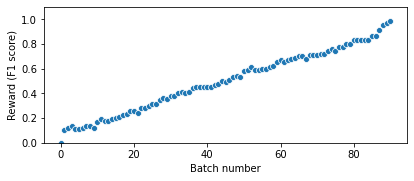

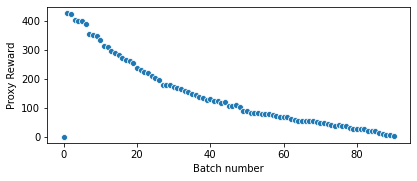

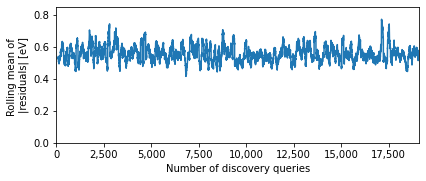

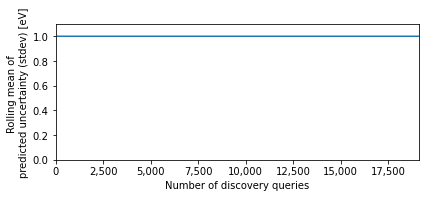

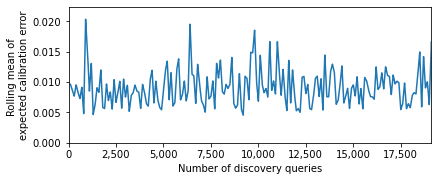

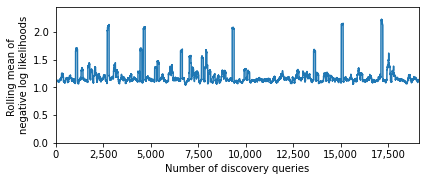

In [6]:
from src.discoverers.adsorption.models import NullModel


model = NullModel(db_dir, quantile_cutoff)
rs_null_discoverer = RandomSearcher(model=model,
                                    quantile_cutoff=quantile_cutoff,
                                    value_calculator=calc_co2rr_activities,
                                    batch_size=batch_size,
                                    training_features=training_features,
                                    training_labels=training_labels,
                                    training_surfaces=training_surfaces,
                                    sampling_features=sampling_features,
                                    sampling_labels=sampling_labels,
                                    sampling_surfaces=sampling_surfaces,
                                    init_train=False    # Set to `False` only for warm starts
                                    )

rs_null_discoverer.load_last_run()
_ = rs_null_discoverer.plot_performance(window=100)

## Random sampling with CFGP

In [7]:
cd ../CFGP

/home/jovyan/catalyst-acquisitions/notebooks/random/CFGP


### Loaded preprocessed data from:  ['/home/jovyan/catalyst-acquisitions/notebooks/pull_data/CO/data.pt']
cmd:
  checkpoint_dir: /home/jovyan/catalyst-acquisitions/notebooks/random/CFGP/checkpoints/2020-09-30-14-54-41-cnn
  identifier: cnn
  logs_dir: /home/jovyan/catalyst-acquisitions/notebooks/random/CFGP/logs/tensorboard/2020-09-30-14-54-41-cnn
  print_every: 100
  results_dir: /home/jovyan/catalyst-acquisitions/notebooks/random/CFGP/results/2020-09-30-14-54-41-cnn
  seed: null
  timestamp: 2020-09-30-14-54-41-cnn
dataset:
  src: /home/jovyan/catalyst-acquisitions/notebooks/pull_data/CO
  test_size: 0
  train_size: 1
  val_size: 0
logger: tensorboard
model: cgcnn
model_attributes:
  atom_embedding_size: 64
  fc_feat_size: 128
  num_fc_layers: 4
  num_graph_conv_layers: 6
  regress_forces: false
optim:
  batch_size: 64
  lr_gamma: 0.1
  lr_initial: 0.001
  lr_milestones:
  - 25
  - 45
  max_epochs: 50
  num_gpus: 2
  warmup_epochs: 10
  warmup_factor: 0.2
task:
  dataset: gasdb
  des

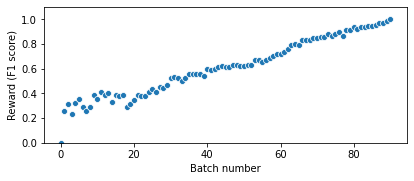

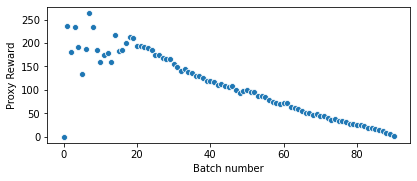

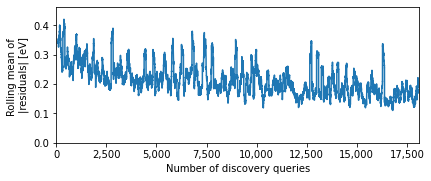

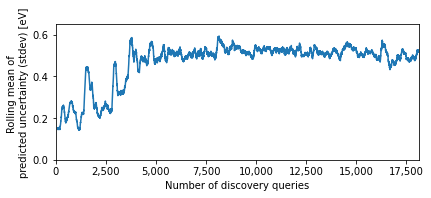

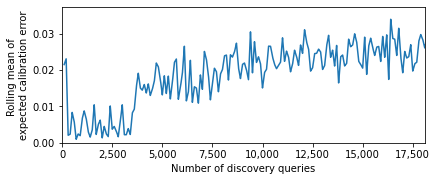

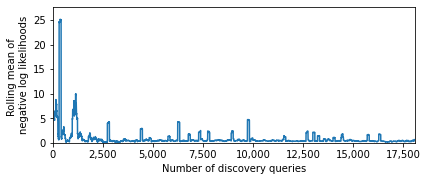

In [8]:
from src.discoverers.adsorption.models import CFGP


model = CFGP(db_dir)
rs_cfgp_discoverer = RandomSearcher(model=model,
                                    quantile_cutoff=quantile_cutoff,
                                    value_calculator=calc_co2rr_activities,
                                    batch_size=batch_size,
                                    training_features=training_features,
                                    training_labels=training_labels,
                                    training_surfaces=training_surfaces,
                                    sampling_features=sampling_features,
                                    sampling_labels=sampling_labels,
                                    sampling_surfaces=sampling_surfaces,
                                    init_train=False    # Set to `False` only for warm starts
                                    )

rs_cfgp_discoverer.load_last_run()
_ = rs_cfgp_discoverer.plot_performance(window=100)

# Delete the checkpoint folder that wandb just automatically made
checkpoint_folders = os.listdir('checkpoints/')
checkpoint_folders.sort()
checkpoint_folder = checkpoint_folders[-1]
checkpoint_folder = os.path.join(os.getcwd(), 'checkpoints', checkpoint_folder)
os.rmdir(checkpoint_folder)

## Random sampling with prime model

In [9]:
cd ../prime

/home/jovyan/catalyst-acquisitions/notebooks/random/prime


### Loaded preprocessed data from:  ['/home/jovyan/catalyst-acquisitions/notebooks/pull_data/CO/data.pt']


/home/jovyan/catalyst-acquisitions/src/discoverers/base.py:426: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  _ = ax.set_ylim([0., np.nanmax(rolled_values) * 1.1])


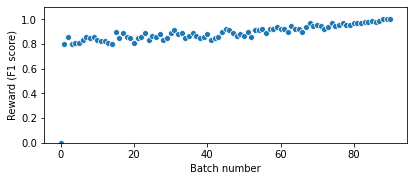

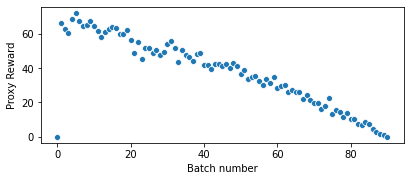

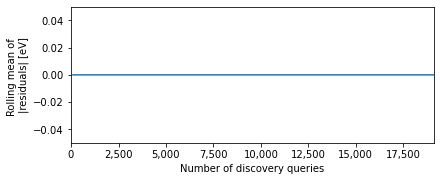

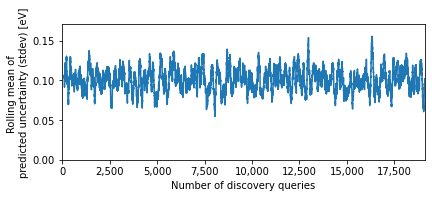

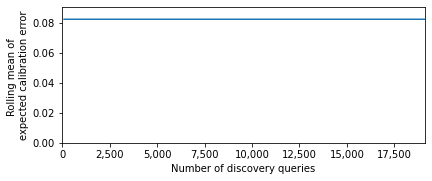

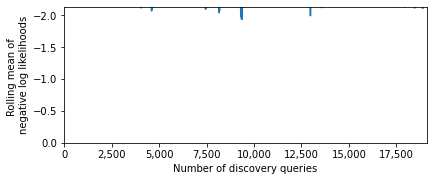

In [10]:
from src.discoverers.adsorption.models import PrimeModel


model = PrimeModel(db_dir)
rs_prime_discoverer = RandomSearcher(model=model,
                                     quantile_cutoff=quantile_cutoff,
                                     value_calculator=calc_co2rr_activities,
                                     batch_size=batch_size,
                                     training_features=training_features,
                                     training_labels=training_labels,
                                     training_surfaces=training_surfaces,
                                     sampling_features=sampling_features,
                                     sampling_labels=sampling_labels,
                                     sampling_surfaces=sampling_surfaces,
                                     init_train=False    # Set to `False` only for warm starts
                                     )

rs_prime_discoverer.load_last_run()
_ = rs_prime_discoverer.plot_performance(window=100)

# MMS Procedures

In [11]:
from src.discoverers.adsorption.mms import MultiscaleDiscoverer

## MMS with null model

In [12]:
cd ../../MMS/null

/home/jovyan/catalyst-acquisitions/notebooks/MMS/null


### Loaded preprocessed data from:  ['/home/jovyan/catalyst-acquisitions/notebooks/pull_data/CO/data.pt']


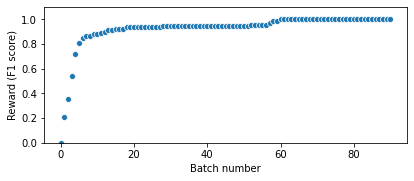

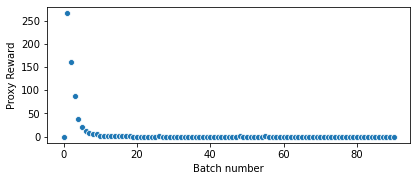

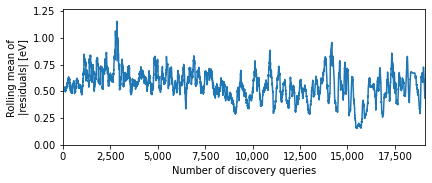

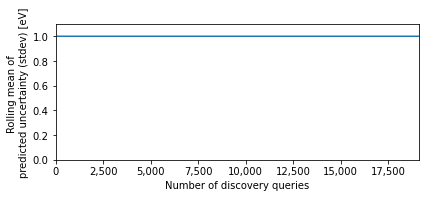

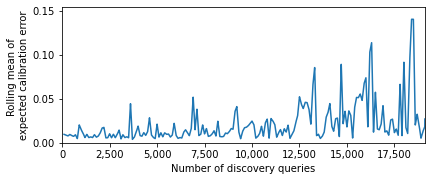

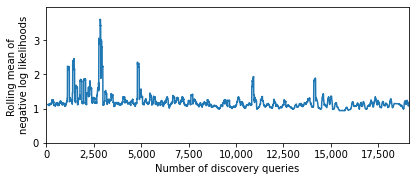

In [13]:
from src.discoverers.adsorption.models import NullModel


model = NullModel(db_dir, quantile_cutoff)
mms_null_discoverer = MultiscaleDiscoverer(model=model,
                                           quantile_cutoff=quantile_cutoff,
                                           value_calculator=calc_co2rr_activities,
                                           batch_size=batch_size,
                                           training_features=training_features,
                                           training_labels=training_labels,
                                           training_surfaces=training_surfaces,
                                           sampling_features=sampling_features,
                                           sampling_labels=sampling_labels,
                                           sampling_surfaces=sampling_surfaces,
                                           init_train=False  # Set to `False` only for warm starts
                                           )

mms_null_discoverer.load_last_run()
_ = mms_null_discoverer.plot_performance(window=100)

## MMS with CFGP

In [14]:
cd ../CFGP

/home/jovyan/catalyst-acquisitions/notebooks/MMS/CFGP


### Loaded preprocessed data from:  ['/home/jovyan/catalyst-acquisitions/notebooks/pull_data/CO/data.pt']
cmd:
  checkpoint_dir: /home/jovyan/catalyst-acquisitions/notebooks/MMS/CFGP/checkpoints/2020-09-30-14-55-10-cnn
  identifier: cnn
  logs_dir: /home/jovyan/catalyst-acquisitions/notebooks/MMS/CFGP/logs/tensorboard/2020-09-30-14-55-10-cnn
  print_every: 100
  results_dir: /home/jovyan/catalyst-acquisitions/notebooks/MMS/CFGP/results/2020-09-30-14-55-10-cnn
  seed: null
  timestamp: 2020-09-30-14-55-10-cnn
dataset:
  src: /home/jovyan/catalyst-acquisitions/notebooks/pull_data/CO
  test_size: 0
  train_size: 1
  val_size: 0
logger: tensorboard
model: cgcnn
model_attributes:
  atom_embedding_size: 64
  fc_feat_size: 128
  num_fc_layers: 4
  num_graph_conv_layers: 6
  regress_forces: false
optim:
  batch_size: 64
  lr_gamma: 0.1
  lr_initial: 0.001
  lr_milestones:
  - 25
  - 45
  max_epochs: 50
  num_gpus: 2
  warmup_epochs: 10
  warmup_factor: 0.2
task:
  dataset: gasdb
  description:

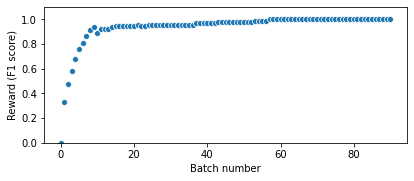

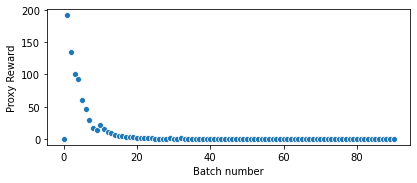

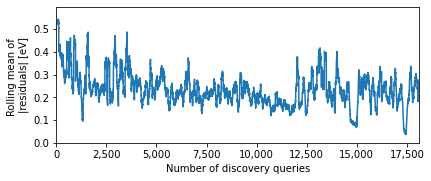

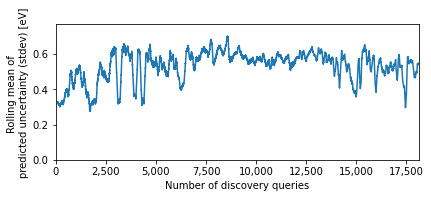

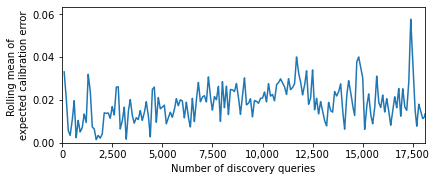

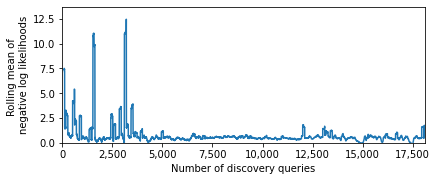

In [15]:
from src.discoverers.adsorption.models import CFGP


# Initialize
model = CFGP(db_dir)
mms_cfgp_discoverer = MultiscaleDiscoverer(model=model,
                                           value_calculator=calc_co2rr_activities,
                                           quantile_cutoff=quantile_cutoff,
                                           batch_size=batch_size,
                                           training_features=training_features,
                                           training_labels=training_labels,
                                           training_surfaces=training_surfaces,
                                           sampling_features=sampling_features,
                                           sampling_labels=sampling_labels,
                                           sampling_surfaces=sampling_surfaces,
                                           init_train=False  # Set to `False` only for warm starts
                                           )

mms_cfgp_discoverer.load_last_run()
_ = mms_cfgp_discoverer.plot_performance(window=100)

# Delete the checkpoint folder that wandb just automatically made
checkpoint_folders = os.listdir('checkpoints/')
checkpoint_folders.sort()
checkpoint_folder = checkpoint_folders[-1]
checkpoint_folder = os.path.join(os.getcwd(), 'checkpoints', checkpoint_folder)
os.rmdir(checkpoint_folder)

## MMS with prime

In [16]:
cd ../prime

/home/jovyan/catalyst-acquisitions/notebooks/MMS/prime


### Loaded preprocessed data from:  ['/home/jovyan/catalyst-acquisitions/notebooks/pull_data/CO/data.pt']


/home/jovyan/catalyst-acquisitions/src/discoverers/base.py:426: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  _ = ax.set_ylim([0., np.nanmax(rolled_values) * 1.1])


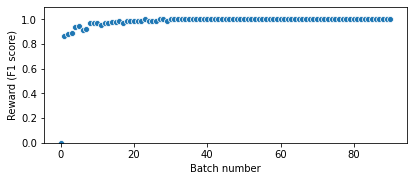

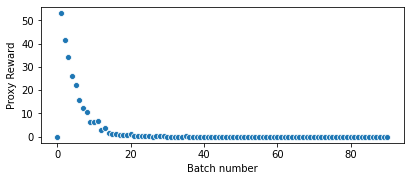

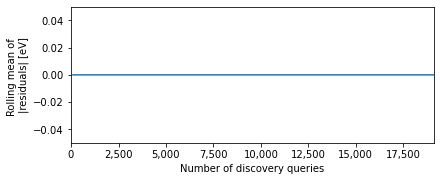

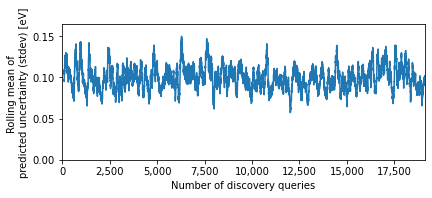

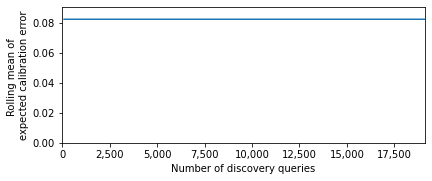

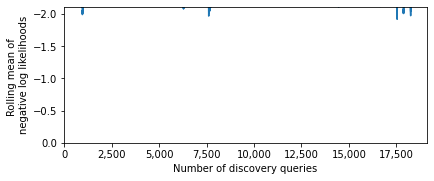

In [17]:
from src.discoverers.adsorption.models import PrimeModel


model = PrimeModel(db_dir)
mms_prime_discoverer = MultiscaleDiscoverer(model=model,
                                            quantile_cutoff=quantile_cutoff,
                                            value_calculator=calc_co2rr_activities,
                                            batch_size=batch_size,
                                            training_features=training_features,
                                            training_labels=training_labels,
                                            training_surfaces=training_surfaces,
                                            sampling_features=sampling_features,
                                            sampling_labels=sampling_labels,
                                            sampling_surfaces=sampling_surfaces,
                                            init_train=False    # Set to `False` only for warm starts
                                            )

mms_prime_discoverer.load_last_run()
_ = mms_prime_discoverer.plot_performance(window=100)

# Gaussian sampling proceduces
## Gaussian with TPOT
Note:  You'll only be able to run this if you're on Laikapack, are using the `kubeflow_catalyst_acquisitions` image, and have GASpy cloned to your home folder.

In [18]:
cd ../../gaussian/TPOT

/home/jovyan/catalyst-acquisitions/notebooks/gaussian/TPOT


In [19]:
import os


sys.path.insert(0, '/home/jovyan/GASpy')
sys.path.insert(0, '/home/jovyan/GASpy/GASpy_regressions')
os.environ['PYTHONPATH'] = '/home/jovyan/GASpy:/home/jovyan/GASpy_regressions'

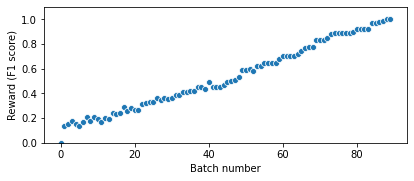

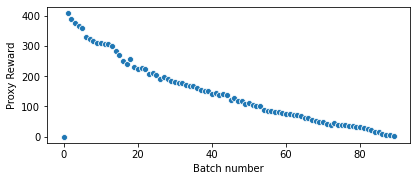

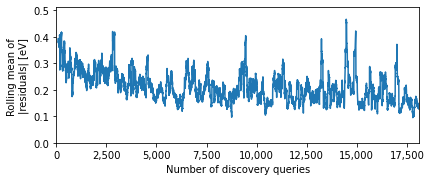

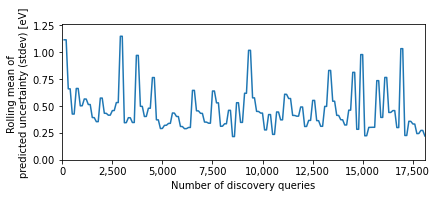

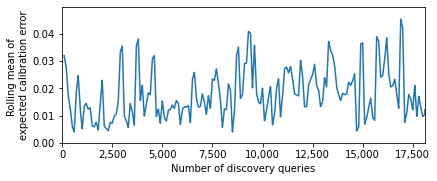

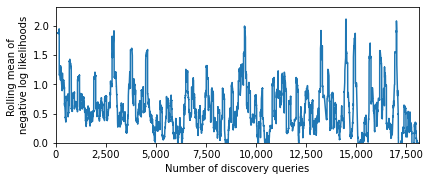

In [21]:
from src.discoverers.adsorption.gaussian import GaussianDiscoverer
from src.discoverers.adsorption.models.tpot import TPOT


model = TPOT()
gaussian_tpot_discoverer = GaussianDiscoverer(model=model,
                                              quantile_cutoff=quantile_cutoff,
                                              target_energy=target_energy,
                                              value_calculator=calc_co2rr_activities,
                                              batch_size=batch_size,
                                              training_features=training_features,
                                              training_labels=training_labels,
                                              training_surfaces=training_surfaces,
                                              sampling_features=sampling_features,
                                              sampling_labels=sampling_labels,
                                              sampling_surfaces=sampling_surfaces,
                                              init_train=False    # Set to `False` only for warm starts
                                              )

gaussian_tpot_discoverer.load_last_run()
_ = gaussian_tpot_discoverer.plot_performance(window=100)

# Comparison

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns


FORMATTER = ticker.FuncFormatter(lambda x, p: format(int(x), ','))
FIG_SIZE = (6.5, 2.5)
#FIG_SIZE = (13, 5)


def plot_rolling_metric(ax, metric_values, metric_name, label=None,
                        window=200, smoother='mean', unit='', **kwargs):
    '''
    Helper function to plot model performance metrics across time in
    hallucination.

    Args:
        ax              Matplotlib ax object to plot onto
        metric_values   A sequence of floats that will be plotted against
                        batch number in the hallucination.
        metric_name     A string indicating what you want the values to be
                        labeled as in the plots.
        label           A string indicating the label you want to use for
                        the data
        window          How many points to roll over during each iteration
        smoother        String indicating how you want to smooth the
                        residuals over the course of the hallucination.
                        Corresponds exactly to the methods of the
                        `pandas.DataFrame.rolling` class, e.g., 'mean',
                        'median', 'min', 'max', 'std', 'sum', etc.
        unit            [Optional] String indicating the units you want to
                        label the plot with
        kwargs          Keyword arguments to pass to `sns.lineplot`
    '''
    # Format the data
    df = pd.DataFrame(metric_values, columns=[metric_name])
    rolling_residuals = getattr(df, metric_name).rolling(window=window)
    rolled_values = getattr(rolling_residuals, smoother)().values
    query_numbers = list(range(len(rolled_values)))

    # Create and format the figure
    _ = sns.lineplot(query_numbers, rolled_values, ax=ax, label=label, **kwargs)
    _ = ax.set_xlabel('Number of discovery queries')
    if unit:
        unit = ' [' + unit + ']'
    _ = ax.set_ylabel('Rolling %s of \n%s%s' % (smoother, metric_name, unit))
    _ = ax.set_xlim([query_numbers[0], query_numbers[-1]])
    _ = ax.set_ylim([0., np.nanmax(rolled_values) * 1.1])
    _ = fig.set_size_inches(*FIG_SIZE)
    _ = ax.get_xaxis().set_major_formatter(FORMATTER)
    return fig

## F1 Score

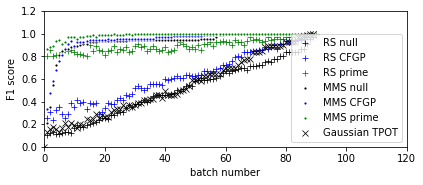

In [24]:
fig = plt.figure()

ax_rs_null = sns.scatterplot(list(range(len(rs_null_discoverer.reward_history))),
                             rs_null_discoverer.reward_history,
                             label='RS null', marker='+', color='black')
ax_rs_cfgp = sns.scatterplot(list(range(len(rs_cfgp_discoverer.reward_history))),
                             rs_cfgp_discoverer.reward_history,
                             label='RS CFGP', marker='+', color='blue')
ax_rs_prime = sns.scatterplot(list(range(len(rs_prime_discoverer.reward_history))),
                              rs_prime_discoverer.reward_history,
                              label='RS prime', marker='+', color='green')
ax_mms_null = sns.scatterplot(list(range(len(mms_null_discoverer.reward_history))),
                              mms_null_discoverer.reward_history,
                              label='MMS null', marker='.', color='black')
ax_mms_cfgp = sns.scatterplot(list(range(len(mms_cfgp_discoverer.reward_history))),
                              mms_cfgp_discoverer.reward_history,
                              label='MMS CFGP', marker='.', color='blue')
ax_mms_prime = sns.scatterplot(list(range(len(mms_prime_discoverer.reward_history))),
                              mms_prime_discoverer.reward_history,
                              label='MMS prime', marker='.', color='green')
ax_gauss_tpot = sns.scatterplot(list(range(len(gaussian_tpot_discoverer.reward_history))),
                                gaussian_tpot_discoverer.reward_history,
                                label='Gaussian TPOT', marker='x', color='black')

_ = ax_rs_null.set_xlabel('batch number')
_ = ax_rs_null.set_ylabel('F1 score')
_ = ax_rs_null.set_xlim(0, 120)
_ = ax_rs_null.set_ylim(0., 1.2)
_ = fig.set_size_inches(*FIG_SIZE)
_ = ax_rs_null.get_xaxis().set_major_formatter(FORMATTER)

## Proxy reward

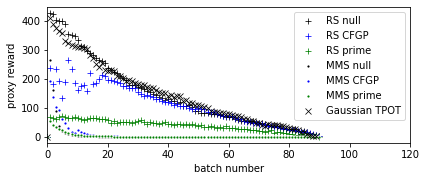

In [25]:
fig = plt.figure()

ax_rs_null = sns.scatterplot(list(range(len(rs_null_discoverer.proxy_reward_history))),
                             rs_null_discoverer.proxy_reward_history,
                             label='RS null', marker='+', color='black')
ax_rs_cfgp = sns.scatterplot(list(range(len(rs_cfgp_discoverer.proxy_reward_history))),
                             rs_cfgp_discoverer.proxy_reward_history,
                             label='RS CFGP', marker='+', color='blue')
ax_rs_prime = sns.scatterplot(list(range(len(rs_prime_discoverer.proxy_reward_history))),
                              rs_prime_discoverer.proxy_reward_history,
                              label='RS prime', marker='+', color='green')
ax_mms_null = sns.scatterplot(list(range(len(mms_null_discoverer.proxy_reward_history))),
                              mms_null_discoverer.proxy_reward_history,
                              label='MMS null', marker='.', color='black')
ax_mms_cfgp = sns.scatterplot(list(range(len(mms_cfgp_discoverer.proxy_reward_history))),
                              mms_cfgp_discoverer.proxy_reward_history,
                              label='MMS CFGP', marker='.', color='blue')
ax_mms_prime = sns.scatterplot(list(range(len(mms_prime_discoverer.proxy_reward_history))),
                              mms_prime_discoverer.proxy_reward_history,
                              label='MMS prime', marker='.', color='green')
ax_gauss_tpot = sns.scatterplot(list(range(len(gaussian_tpot_discoverer.proxy_reward_history))),
                                gaussian_tpot_discoverer.proxy_reward_history,
                                label='Gaussian TPOT', marker='x', color='black')

_ = ax_rs_null.set_xlabel('batch number')
_ = ax_rs_null.set_ylabel('proxy reward')
_ = ax_rs_null.set_xlim(0, 120)
_ = fig.set_size_inches(*FIG_SIZE)
_ = ax_rs_null.get_xaxis().set_major_formatter(FORMATTER)

## Residuals

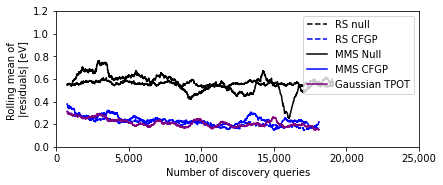

In [26]:
fig = plt.figure()
ax = fig.gca()
window = 750

_ = plot_rolling_metric(ax=ax,
                       metric_values=np.abs(rs_null_discoverer.residuals),
                       label='RS null',
                       metric_name='|residuals|',
                       unit='eV',
                       window=window,
                       color='black')
_ = plot_rolling_metric(ax=ax,
                        metric_values=np.abs(rs_cfgp_discoverer.residuals),
                        label='RS CFGP',
                        metric_name='|residuals|',
                        unit='eV',
                        window=window,
                        color='blue')
#_ = plot_rolling_metric(ax=ax,
#                        metric_values=np.abs(rs_prime_discoverer.residuals),
#                        label='RS prime',
#                        metric_name='|residuals|',
#                        unit='eV',
#                        window=window,
#                        color='green')
_ = plot_rolling_metric(ax=ax,
                        metric_values=np.abs(mms_null_discoverer.residuals),
                        label='MMS Null',
                        metric_name='|residuals|',
                        unit='eV',
                        window=window,
                        color='black')
_ = plot_rolling_metric(ax=ax,
                        metric_values=np.abs(mms_cfgp_discoverer.residuals),
                        label='MMS CFGP',
                        metric_name='|residuals|',
                        unit='eV',
                        window=window,
                        color='blue')
#_ = plot_rolling_metric(ax=ax,
#                        metric_values=np.abs(mms_prime_discoverer.residuals),
#                        label='MMS prime',
#                        metric_name='|residuals|',
#                        unit='eV',
#                        window=window,
#                        color='green')
_ = plot_rolling_metric(ax=ax,
                        metric_values=np.abs(gaussian_tpot_discoverer.residuals),
                        label='Gaussian TPOT',
                        metric_name='|residuals|',
                        unit='eV',
                        window=window,
                        color='purple')

#for line in ax.lines[:3]:
for line in ax.lines[:2]:
    line.set_linestyle('--')
_ = ax.legend()
_ = ax.set_ylim([0., 1.2])
_ = ax.set_xlim([0., 25000])

## Calibration

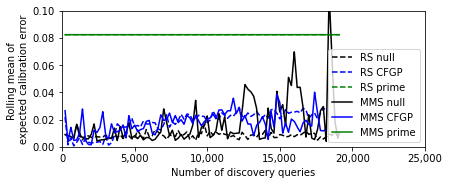

In [22]:
from tqdm.notebook import tqdm


fig = plt.figure()
ax = fig.gca()


def calculate_eces(discoverer, window=200):
    # Divide the data into chunks, which we need to calculate ECE
    chunked_residuals = discoverer.chunk_iterable(discoverer.residuals, window)
    chunked_uncertainties = discoverer.chunk_iterable(discoverer.uncertainties, window)

    # Calculate ECE
    loop = tqdm(zip(chunked_residuals, chunked_uncertainties),
                desc='calibration', unit='batch', total=len(chunked_residuals))
    for resids, stdevs in loop:
        ece = discoverer.calculate_expected_calibration_error(resids, stdevs)
        try:
            eces.extend([ece] * len(resids))
        # EAFP for initialization
        except NameError:
            eces = [ece] * len(resids)
    return eces


_ = plot_rolling_metric(ax=ax,
                        metric_values=calculate_eces(rs_null_discoverer),
                        label='RS null',
                        metric_name='expected calibration error',
                        color='black')
_ = plot_rolling_metric(ax=ax,
                        metric_values=calculate_eces(rs_cfgp_discoverer),
                        label='RS CFGP',
                        metric_name='expected calibration error',
                        color='blue')
_ = plot_rolling_metric(ax=ax,
                        metric_values=calculate_eces(rs_prime_discoverer),
                        label='RS prime',
                        metric_name='expected calibration error',
                        color='green')
_ = plot_rolling_metric(ax=ax,
                        metric_values=calculate_eces(mms_null_discoverer),
                        label='MMS null',
                        metric_name='expected calibration error',
                        color='black')
_ = plot_rolling_metric(ax=ax,
                        metric_values=calculate_eces(mms_cfgp_discoverer),
                        label='MMS CFGP',
                        metric_name='expected calibration error',
                        color='blue')
_ = plot_rolling_metric(ax=ax,
                        metric_values=calculate_eces(mms_prime_discoverer),
                        label='MMS prime',
                        metric_name='expected calibration error',
                        color='green')

for line in ax.lines[:3]:
#for line in ax.lines[:2]:
    line.set_linestyle('--')
_ = ax.legend()
_ = ax.set_ylim([0., 0.1])
_ = ax.set_xlim([0., 25000])

## Sharpness

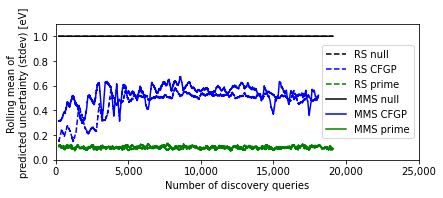

In [23]:
fig = plt.figure()
ax = fig.gca()

_ = plot_rolling_metric(ax=ax,
                        metric_values=np.abs(rs_null_discoverer.uncertainties),
                        label='RS null',
                        metric_name='predicted uncertainty (stdev)',
                        unit='eV',
                        color='black')
_ = plot_rolling_metric(ax=ax,
                        metric_values=np.abs(rs_cfgp_discoverer.uncertainties),
                        label='RS CFGP',
                        metric_name='predicted uncertainty (stdev)',
                        unit='eV',
                        color='blue')
_ = plot_rolling_metric(ax=ax,
                        metric_values=np.abs(rs_prime_discoverer.uncertainties),
                        label='RS prime',
                        metric_name='predicted uncertainty (stdev)',
                        unit='eV',
                        color='green')
_ = plot_rolling_metric(ax=ax,
                        metric_values=np.abs(mms_null_discoverer.uncertainties),
                        label='MMS null',
                        metric_name='predicted uncertainty (stdev)',
                        unit='eV',
                        color='black')
_ = plot_rolling_metric(ax=ax,
                        metric_values=np.abs(mms_cfgp_discoverer.uncertainties),
                        label='MMS CFGP',
                        metric_name='predicted uncertainty (stdev)',
                        unit='eV',
                        color='blue')
_ = plot_rolling_metric(ax=ax,
                        metric_values=np.abs(mms_prime_discoverer.uncertainties),
                        label='MMS prime',
                        metric_name='predicted uncertainty (stdev)',
                        unit='eV',
                        color='green')

for line in ax.lines[:3]:
    line.set_linestyle('--')
_ = ax.legend()
_ = ax.set_ylim([0., 1.1])
_ = ax.set_xlim([0., 25000])

## NLL

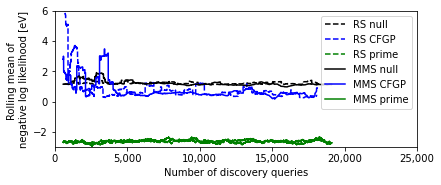

In [24]:
from scipy.stats import norm


window = 600
fig = plt.figure()
ax = fig.gca()


def calculate_nlls(discoverer):
    nlls = [-norm.logpdf(resid, loc=0., scale=std)
            for resid, std in zip(discoverer.residuals, discoverer.uncertainties)]
    return nlls


_ = plot_rolling_metric(ax=ax,
                        metric_values=calculate_nlls(rs_null_discoverer),
                        label='RS null',
                        metric_name='negative log likelihood',
                        unit='eV',
                        window=window,
                        color='black')
_ = plot_rolling_metric(ax=ax,
                        metric_values=calculate_nlls(rs_cfgp_discoverer),
                        label='RS CFGP',
                        metric_name='negative log likelihood',
                        unit='eV',
                        window=window,
                        color='blue')
_ = plot_rolling_metric(ax=ax,
                        metric_values=calculate_nlls(rs_prime_discoverer),
                        label='RS prime',
                        metric_name='negative log likelihood',
                        unit='eV',
                        window=window,
                        color='green')
_ = plot_rolling_metric(ax=ax,
                        metric_values=calculate_nlls(mms_null_discoverer),
                        label='MMS null',
                        metric_name='negative log likelihood',
                        unit='eV',
                        window=window,
                        color='black')
_ = plot_rolling_metric(ax=ax,
                        metric_values=calculate_nlls(mms_cfgp_discoverer),
                        label='MMS CFGP',
                        metric_name='negative log likelihood',
                        unit='eV',
                        window=window,
                        color='blue')
_ = plot_rolling_metric(ax=ax,
                        metric_values=calculate_nlls(mms_prime_discoverer),
                        label='MMS prime',
                        metric_name='negative log likelihood',
                        unit='eV',
                        window=window,
                        color='green')

for line in ax.lines[:3]:
    line.set_linestyle('--')
_ = ax.legend()
_ = ax.set_ylim([-3, 6.])
_ = ax.set_xlim([0., 25000])

# Comparing F1 score and proxy reward

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


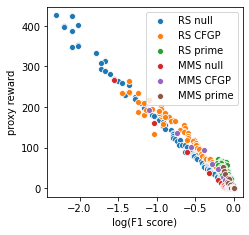

In [41]:
fig = plt.figure(figsize=(3.5, 3.5))
ax = fig.gca()

f1_scores = {'RS null': rs_null_discoverer.reward_history,
             'RS CFGP': rs_cfgp_discoverer.reward_history,
             'RS prime': rs_prime_discoverer.reward_history,
             'MMS null': mms_null_discoverer.reward_history,
             'MMS CFGP': mms_cfgp_discoverer.reward_history,
             'MMS prime': mms_prime_discoverer.reward_history}

proxy_rewards = {'RS null': rs_null_discoverer.proxy_reward_history,
                 'RS CFGP': rs_cfgp_discoverer.proxy_reward_history,
                 'RS prime': rs_prime_discoverer.proxy_reward_history,
                 'MMS null': mms_null_discoverer.proxy_reward_history,
                 'MMS CFGP': mms_cfgp_discoverer.proxy_reward_history,
                 'MMS prime': mms_prime_discoverer.proxy_reward_history}

for key, f1s in f1_scores.items():
    proxies = proxy_rewards[key]
    f1s = np.log(f1s)
    sns.scatterplot(f1s, proxies, label=key)

_ = ax.set_xlabel('log(F1 score)')
_ = ax.set_ylabel('proxy reward')